# [Hyperparameter](https://bit.ly/3a1ZTyP) Optimization


### Celem jest poznanie sposobów, jak można dobierać parametry modelu.

Uwaga! Dobór parametrów to zwykle ostatni krok i na to poświęca się maksymalnie ok. 5-7% czasu (prośba nie zaczynaj konkursu od uruchomienia `hyperopt` :D).

Każdy (w miarę zaawansowany) model ma parametry, które są ustawiane "na zewnątrz". Na przykład w drzewach decyzyjnych jest to maksymalna głębokość albo minimalna liczba obiektów w liściach. W lasach losowych dodatkowym parametrem jest liczba modeli (drzew) itd.

W praktyce oznacza to, że znalezienie [najlepszych "hyperparameterów"](https://bit.ly/3d94WQ8) dla danego modelu ma wpływ na jego jakość.

_"Najlepsze" oznacza najlepszą metrykę sukcesu dla wybranych hyperparametrów._

Istnieje kilka podejść do tego zagadnienia:
* GridSearch ([GridSearchCV](https://bit.ly/3mEiG8g)
* [Random Search](https://bit.ly/2OEz0tn) ([RandomizedSearchCV](https://bit.ly/3a21gxm) )
* [Bayesian optimization](https://bit.ly/2RrSimP) (np. [hyperopt](https://bit.ly/3s3RRM9))

![grid and random tuning](../images/tuning.png)

Spróbujmy to zrozumieć na przykładzie. Dlaczego używanie złego narzędzia (np. `GridSearch`) może zaboleć i to dość mocno?

Odwołajmy się do przykładu i popatrzmy na wszystkie hyperparametry [XGBoost](https://bit.ly/3mEdwJF)'a:
- **max_depth** : int, *Maximum tree depth for base learners.*
- **learning_rate** : float, *Boosting learning rate (xgb’s “eta”)*
- **n_estimators** : int, *Number of boosted trees to fit.*
- silent : boolean, *Whether to print messages while running boosting.*
- **objective** : string or callable, *Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).*
- nthread : int, *Number of parallel threads used to run xgboost.*
- **gamma** : float, *Minimum loss reduction required to make a further partition on a leaf node of the tree.*
- **min_child_weight** : int, *Minimum sum of instance weight(hessian) needed in a child.*
max_delta_step : int, *Maximum delta step we allow each tree’s weight estimation to be.*
- **subsample** : float, *Subsample ratio of the training instance.*
- **colsample_bytree** : float, *Subsample ratio of columns when constructing each tree.*
- **colsample_bylevel** : float, *Subsample ratio of columns for each split, in each level.*
- **reg_alpha** : float (xgb’s alpha), *L1 regularization term on weights*
- **reg_lambda** : float (xgb’s lambda), *L2 regularization term on weights*
- scale_pos_weight : float, *Balancing of positive and negative weights.*
- base_score: *The initial prediction score of all instances, global bias.*
- **random_state** : int, *Random number seed.*
- missing : float, optional, *Value in the data which needs to be present as a missing value. If None, defaults to np.nan.*

XGBoost posiada co najmniej 12 hyperparametrów (**pogrubione**), które warto dobierać. Używając `GridSearch` musimy zdefiniować zakres dokładnych wartości do sprawdzenia dla każdego parametru. I dla każdego takiego zestawu parametrów trzeba zbudować oddzielny model.

Możemy na szybko wyliczyć, ile razy powinniśmy zbudować model stosując `GridSearch`:

`hyper_parameters` (liczba hyperparameterów) ^ `N` (możliwe wartości) * `validation` (np. k-fold validation).

Przykład:
* `hyper_parameters` = 12
* `N` = 10
* `validation` = 3

Dodatkowo każdy model potrzebuje czasu, aby się wytrenować (`time_per_iteration`).

`10^12 * 3 * time_per_iteration` = bardzo duża liczba! Nawet jeśli `time_per_iteration` będzie 1s to potrzebujesz co najmniej **~95 000 lat** :). A i to przy założeniu, że wiedzieliśmy jaki zakres parametrów powinniśmy sprawdzić. 

Dlatego używanie `GridSearch`, które jest podejściem typu `brute-force`, nie działa na większą skalę.

`RandomSearch` próbuje to częściowo naprawić. Zamiast na sztywno wybierać wartości parametrów, podajemy przedziały, z których będą losowane te wartości. W ten sposób zwiększamy szansę na szybsze znalezienie optymalnych parametrów, niż przy próbie sprawdzania każdej opcji za pomocą `GridSearch`. 

Wadą tego rozwiązania jest to, że robi to w totalnie losowy sposób, nie wykorzystując w żaden sposób wiedzy z poprzednich losowań. 

Jakie podejście w takim razie byłoby najefektywniejsze?
Na poziomie intuicji można to zrozumieć tak, że optymalizując parametry, chcemy dokładniej zbadać te obszary, które mają największy potencjał na polepszenie wyników naszego modelu, a mniej dokładnie te, w których szanse na znalezienie lepszych wartości dla parametrów są prawie zerowe. 

Tutaj z pomocą przychodzi nam właśnie `Bayesian optimization`, które jest wykorzystywane w `hyperopt`.

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.datasets import make_regression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,4)
import seaborn as sns

%matplotlib inline

## Eksperyment
Żeby lepiej zrozumieć, jak działa `hyperopt`, to zrobimy mały eksperyment.

Zbudujmy losową funkcję, która będzie się składać z trzech parametrów. Zakładamy z góry, że te trzy parametry są dla nas znane. Nie będą one jednak znane dla `hyperopt`. 
On będzie wiedział tylko, w jakim przedziale mogą być te zmienne. Innymi słowy zmienna może przyjmować wartość "od... do..." z jakimś rozkładem.

Poniżej:
* funkcja `weights()` zwraca szukane parametry (to jest to, co `hyperopt` ma zgadnąć)
* funkcja `model()` symuluje działanie modelu, który oczekuje na 3 (hyper)parametry.

Poniżej jest linijka kodu z gwiazdką: `y = model(x, *weigths())`. 

Funkcja `weigths()` zwraca trzy elementy (trzy wagi). Gwiazdka wyciąga parametry i przekazuje do modelu. 

Tutaj jest dłuższa wersja kodu, który robi to samo:

```
w1, w2, w3 = weigths()
y = model(x, w1, w2, w2)
```

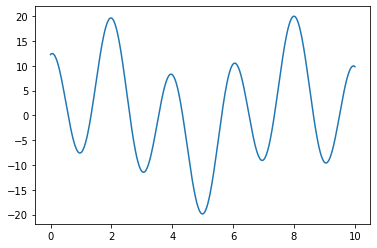

In [3]:
def weights():
    return 7.65, 12.98, 10.23  #prawdziwe wagi, które hyperopt ma znaleźć

def model(x, w1, w2, w3):
    return w1*np.sin(x) + w2*np.cos(np.pi * x) + np.sin(x + w3)


x = np.linspace(0, 10, 500)

w1, w2, w3 = weights()
y = model(x, *weights()) 
plt.plot(x, y);

Tak wygląda wykres funkcji z poprawnymi wagami. 

Teraz zobaczymy, czy `hyperopt` będzie umiał "odgadnąć" wagi, które wyżej zdefiniowaliśmy.

## [Hyperopt](https://bit.ly/3g4Qhai)

Użycie hyperopt można podzielić na trzy części:
- zdefiniowanie funkcji `objective(space)`, która jako argument przyjmuje przestrzeń parametrów i zwraca, jaki jest błąd dla danych parametrów (w `loss` podawane jest to, w jaki sposób będzie liczony błąd). Zwróć uwagę, że dla `hyperopt` wszystko jedno, co się dzieje w środku funkcji `objective`. Ważne jest to, że `hyperopt` przekazuje parametry na wejściu i oczekuje na informację zwrotną, jak duży jest błąd.
- zdefiniowanie **przestrzeni parametrów**, np. `max_depth` zwykle jest od 2-3 do 10 -15.
- uruchomienie funkcji `fmin`, to jest funkcja optymalizująca, która uruchamia optymalizator.

### Przykład:


### objective
 ```
 def objective(space):
    #zbuduj model
    #zrób predykcję
    #policzyć score licząc metrykę sukcesu
    
    return {'loss':score, 'status': STATUS_OK } #score to jest wartość z metryki sukcesu
    
    
```

### Zdefiniowanie przestrzeni parametrów

*Dla uproszczenia:*

Rozkład [uniform](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)) oznacza równomiernie rozłożony. Jeśli podajemy przedział od 0 do 10, to wartości 0 i 10 są równie prawdopodobne.

Rozkład [norm](https://en.wikipedia.org/wiki/Normal_distribution) jest rozkładem normalnym. To znaczy, że wartości mają symetryczny rozkład od wartości średniej i na końcach są najrzadsze wystąpienia.

Prefix `q` oznacza stany dyskretne (w naszym przypadku to po prostu liczby całkowite), zamiast ciągłe (np. 1, 3, 5, ale nie 1.3, 3.4, 5.2 itd). Możemy również podawać krok pomiędzy liczbami. Na przykład dla parametru `max_depth`, jeśli chcemy przechodzić między 5 a 20 co 1 krok, to wtedy mamy: `hp.quniform ('x_max_depth', 5, 20, 1)`. 

**Uwaga**! To nie oznacza przejścia od 5 do 20 w sposób ciągły, `quniform` jedynie gwarantuje, że będzie losować w sposób równomierny wartości dyskretne pomiędzy 5 a 20. Dlatego kolejność będzie losowa i nie musi być uporządkowana. Również więcej niż jeden raz może pojawić się ta sama wartość. 

Więcej szczegółów można znaleźć w *wycinku dokumentacji poniżej*. 

- **hp.choice**(label, options)
Returns one of the options, which should be a list or tuple. The elements of options can themselves be [nested] stochastic expressions. In this case, the stochastic choices that only appear in some of the options become conditional parameters.

- **hp.randint**(label, upper)
Returns a random integer in the range [0, upper). The semantics of this distribution is that there is no more correlation in the loss function between nearby integer values, as compared with more distant integer values. This is an appropriate distribution for describing random seeds for example. If the loss function is probably more correlated for nearby integer values, then you should probably use one of the "quantized" continuous distributions, such as either quniform, qloguniform, qnormal or qlognormal.

- **hp.uniform**(label, low, high)
Returns a value uniformly between low and high.
When optimizing, this variable is constrained to a two-sided interval.

- **hp.quniform**(label, low, high, q)
Returns a value like round(uniform(low, high) / q) * q
Suitable for a discrete value with respect to which the objective is still somewhat "smooth", but which should be bounded both above and below.

- **hp.loguniform**(label, low, high)
Returns a value drawn according to exp(uniform(low, high)) so that the logarithm of the return value is uniformly distributed.
When optimizing, this variable is constrained to the interval [exp(low), exp(high)].

- **hp.qloguniform**(label, low, high, q)
Returns a value like round(exp(uniform(low, high)) / q) * q
Suitable for a discrete variable with respect to which the objective is "smooth" and gets smoother with the size of the value, but which should be bounded both above and below.

- **hp.normal**(label, mu, sigma)
Returns a real value that's normally-distributed with mean mu and standard deviation sigma. When optimizing, this is an unconstrained variable.

- **hp.qnormal**(label, mu, sigma, q)
Returns a value like round(normal(mu, sigma) / q) * q
Suitable for a discrete variable that probably takes a value around mu, but is fundamentally unbounded.

- **hp.lognormal**(label, mu, sigma)
Returns a value drawn according to exp(normal(mu, sigma)) so that the logarithm of the return value is normally distributed. When optimizing, this variable is constrained to be positive.

- **hp.qlognormal**(label, mu, sigma, q)
Returns a value like round(exp(normal(mu, sigma)) / q) * q
Suitable for a discrete variable with respect to which the objective is smooth and gets smoother with the size of the variable, which is bounded from one side.

## Przykład użycia

Spróbujmy teraz użyć `hyperopt` do optymalizacji parametrów dla naszej wcześniej wymyślonej funkcji. 

Przypominam, że funkcja posiada trzy parametry, które nie są znane dla `hyperopt`. Jedyne co "wie", to przedziały (przestrzeń) gdzie ma szukać parametrów. W naszym przypadku to są wartości pomiędzy 0 a 15, rozłożone w sposób równomierny. Innymi słowy prawdopodobieństwo pojawienia się wartości 1 jest takie samo jak wartości 5, 7 czy 14.

Chcemy sprawdzić, jak dużo iteracji potrzebuje `hyperopt`, żeby przybliżyć się do prawidłowych wartości wag. Dlatego zastosujemy różną ilość iteracji (1, 5, 10, 20, 30, 50, 100 i 500) i porównamy wyniki.

Poniższy kawałek kodu na początku może wyglądać na trochę skomplikowany. Na początku nie musisz rozumieć całości, jednak warto go kilka razy na spokojnie przeanalizować.

100%|██████████| 1/1 [00:00<00:00, 312.08trial/s, best loss: 62.787670832464215]
iterations #1: {'x_w1': 0.8604438628207983, 'x_w2': 3.455382349526862, 'x_w3': 14.340173347166978}


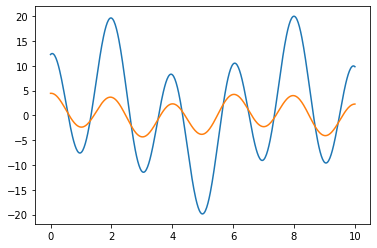

100%|██████████| 5/5 [00:00<00:00, 359.35trial/s, best loss: 12.107721517981693]
iterations #5: {'x_w1': 3.004310908762334, 'x_w2': 13.557316579428841, 'x_w3': 2.757409974136965}


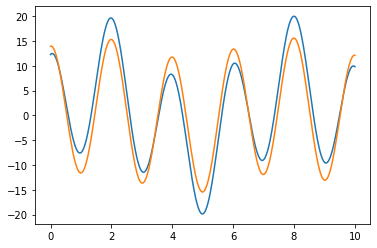

100%|██████████| 10/10 [00:00<00:00, 345.10trial/s, best loss: 1.3132420954719821]
iterations #10: {'x_w1': 4.907749885819605, 'x_w2': 13.83634434321895, 'x_w3': 5.458080661512073}


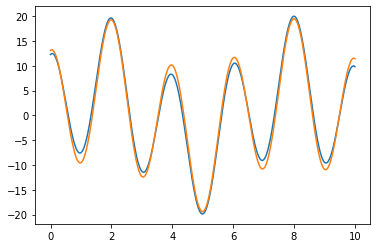

100%|██████████| 20/20 [00:00<00:00, 277.14trial/s, best loss: 0.4971967744344646]
iterations #20: {'x_w1': 7.744614271246147, 'x_w2': 13.126534655783143, 'x_w3': 4.914951923671806}


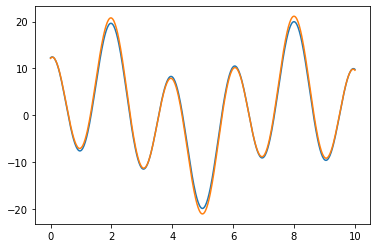

100%|██████████| 30/30 [00:00<00:00, 121.35trial/s, best loss: 0.7513044500926433]
iterations #30: {'x_w1': 7.436662060711154, 'x_w2': 11.76527739380787, 'x_w3': 10.216259859444726}


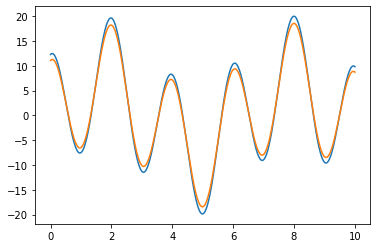

100%|██████████| 50/50 [00:00<00:00, 81.90trial/s, best loss: 0.1454596107075638] 
iterations #50: {'x_w1': 6.040904168566842, 'x_w2': 12.97005852484519, 'x_w3': 5.1321092877093175}


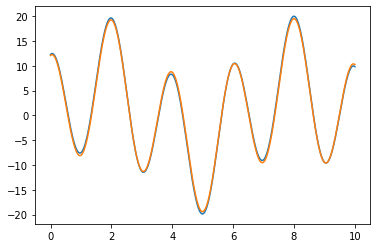

100%|██████████| 100/100 [00:01<00:00, 70.07trial/s, best loss: 0.059832598069417375]
iterations #100: {'x_w1': 6.775534975443342, 'x_w2': 12.763127100532614, 'x_w3': 5.024295812858925}


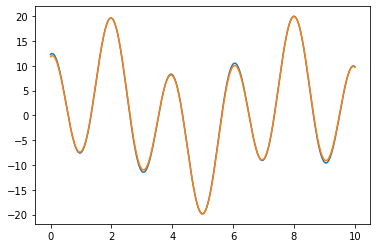

100%|██████████| 500/500 [00:10<00:00, 46.20trial/s, best loss: 0.05734816745771048]
iterations #500: {'x_w1': 6.089842906697441, 'x_w2': 12.666524004079703, 'x_w3': 5.638516535338715}


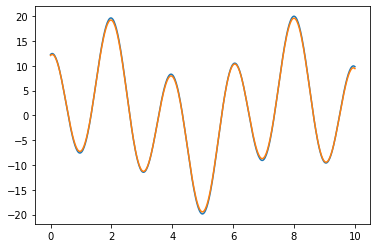

In [4]:
def objective(space):
    pred_value = model(x, space['w1'], space['w2'], space['w3'])
    true_value = model(x, *weights())
    
    score = np.mean( (pred_value - true_value)**2 )
    
    return {'loss':score, 'status': STATUS_OK }
    
space ={
    'w1': hp.uniform ('x_w1', 0, 15),
    'w2': hp.uniform ('x_w2', 0, 15),
    'w3': hp.uniform ('x_w3', 0, 15)
}
  
for max_evals in [1, 5, 10, 20, 30, 50, 100, 500]:
    trials = Trials()
    best_params = fmin(fn=objective, #funkcja optymalizująca zdefiniowana wyżej
                space=space, #przestrzeń potencjalnych (hyper)parametrów
                algo=tpe.suggest, #algorytm użyty to optymalizacji
                max_evals=max_evals, #ilość prób
                trials=trials) #tu są zapisywane wyniki
    

    print("iterations #{0}: {1}".format(max_evals, best_params))
    y_pred = model(x, best_params['x_w1'], best_params['x_w2'], best_params['x_w3'])
    plt.plot(x, y)
    plt.plot(x, y_pred)
    plt.show()

Widać, że już na 30 iteracjach wykresy zaczynają się pokrywać (to oznacza, że parametry są coraz bardziej prawidłowe). Dla 50 iteracji wygląda to jeszcze lepiej.

**Uwaga**. Ciekawostka dotycząca implementacji biblioteki `hyperopt`, o której sam nie wiedziałem dość długo, jest taka, że pierwsze [20 iteracji](https://bit.ly/3t7LoAY) są losowe (czyli to są po prostu losowe próbki, bez żadnej zaawansowanej logiki). Robi się to po to, żeby zdobyć "doświadczenie" i dopiero potem włącza się algorytm optymalizacji. Natomiast ten parametr 20 można zmienić, ustawiając parametr `n_startup_jobs` w `suggest`:

```
#...
algo=partial(tpe.suggest, n_startup_jobs=1)
#...
```

Poniżej jest kod w całości, który pokazuje, jak to można zrobić.

100%|██████████| 1/1 [00:00<00:00, 212.17trial/s, best loss: 24.632278273925262]
iterations #1: {'x_w1': 12.542529457916938, 'x_w2': 9.570325068114006, 'x_w3': 1.3153714225992967}


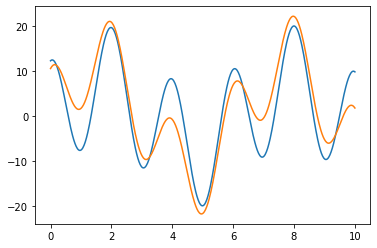

100%|██████████| 5/5 [00:00<00:00, 76.14trial/s, best loss: 4.761430307750439]
iterations #5: {'x_w1': 5.599404227902388, 'x_w2': 14.776737697924727, 'x_w3': 14.804867686656547}


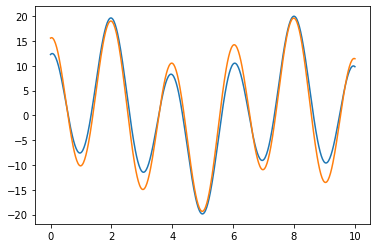

100%|██████████| 10/10 [00:00<00:00, 60.88trial/s, best loss: 2.2194708804169627]
iterations #10: {'x_w1': 7.668531888906656, 'x_w2': 14.9715198893484, 'x_w3': 11.035127294536533}


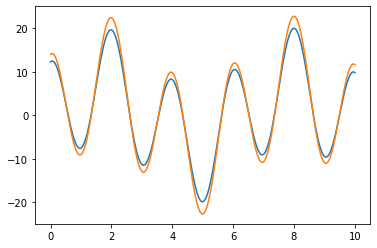

100%|██████████| 20/20 [00:00<00:00, 50.09trial/s, best loss: 0.20476162351237848]
iterations #20: {'x_w1': 5.959552083546346, 'x_w2': 12.9490103824732, 'x_w3': 12.470361905278786}


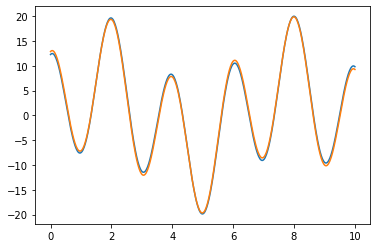

100%|██████████| 30/30 [00:00<00:00, 47.49trial/s, best loss: 1.0690871831634328]
iterations #30: {'x_w1': 6.721337034893489, 'x_w2': 12.908501197819374, 'x_w3': 6.898434744908101}


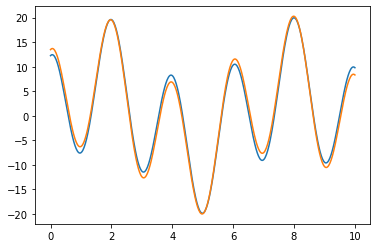

100%|██████████| 50/50 [00:00<00:00, 54.74trial/s, best loss: 1.5431991438844046]
iterations #50: {'x_w1': 9.12104434325429, 'x_w2': 11.867059298374231, 'x_w3': 10.004494433657184}


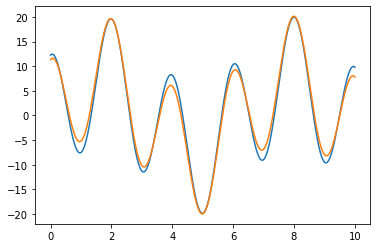

100%|██████████| 100/100 [00:01<00:00, 53.85trial/s, best loss: 0.16904670775862157]
iterations #100: {'x_w1': 6.8756259478857515, 'x_w2': 13.494224794908389, 'x_w3': 4.913809076140264}


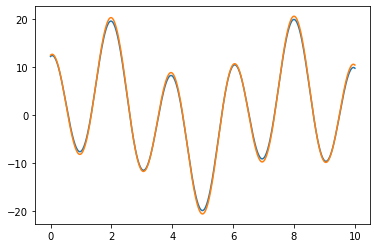

In [5]:
for max_evals in [1, 5, 10, 20, 30, 50, 100]:
    trials = Trials()
    best_params = fmin(fn=objective, #funkcja optymalizacja zdefiniowana wyżej
                space=space, #przestrzeń potencjalnych (hyper)parametrów
                algo=partial(tpe.suggest, n_startup_jobs=1), #algorytm użyty to optymalizacji, tylko pierwsza iteracja jest losowa
                max_evals=max_evals, #ilość prób
                trials=trials) #tu są zapisywane wyniki w trakcie, może przydać się później
    

    print("iterations #{0}: {1}".format(max_evals, best_params))
    y_pred = model(x, best_params['x_w1'], best_params['x_w2'], best_params['x_w3'])
    plt.plot(x, y)
    plt.plot(x, y_pred)
    plt.show()

Teraz już widać, że nawet w okolicy 20 iteracji wyniki są już dość dobre. Dlatego czasem warto zmieniać ten parametr, zwłaszcza jeśli chcemy mieć mniej niż 20 prób :).

## XGBoost
Bardziej realistyczny przykład użycia `hyperopt` z `XGBoost`.

Najpierw stwórzmy sobie dane - niech to będzie 5000 wierszy i 20 kolumn (cech).

In [6]:
X, y = make_regression(n_samples=5000, n_features=20, n_informative=10, noise=15)
X.shape

(5000, 20)

Dzielimy dane:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_squared_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|██████████| 30/30 [01:55<00:00,  3.84s/trial, best loss: 1120.522038152827]
The best params:  {'x_colsample_bytree': 0.8808726612595402, 'x_learning_rate': 0.10300030030597646, 'x_max_depth': 5.0, 'x_min_child_weight': 1.0, 'x_random_state': 6850.0, 'x_reg_alpha': 1.4496477484011536, 'x_reg_lambda': 0.7759296444009006, 'x_subsample': 0.8740751747547388}


## Najlepsza próba
Poniżej możemy podejrzeć, jakie parametry dały najlepszy wynik i jaki był błąd.

In [9]:
trials.best_trial

{'state': 2,
 'tid': 8,
 'spec': None,
 'result': {'loss': 1120.522038152827, 'status': 'ok'},
 'misc': {'tid': 8,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [8],
   'x_learning_rate': [8],
   'x_max_depth': [8],
   'x_min_child_weight': [8],
   'x_random_state': [8],
   'x_reg_alpha': [8],
   'x_reg_lambda': [8],
   'x_subsample': [8]},
  'vals': {'x_colsample_bytree': [0.8808726612595402],
   'x_learning_rate': [0.10300030030597646],
   'x_max_depth': [5.0],
   'x_min_child_weight': [1.0],
   'x_random_state': [6850.0],
   'x_reg_alpha': [1.4496477484011536],
   'x_reg_lambda': [0.7759296444009006],
   'x_subsample': [0.8740751747547388]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 5, 16, 15, 48, 11, 816000),
 'refresh_time': datetime.datetime(2021, 5, 16, 15, 48, 12, 258000)}

## Zadanie 3.3.1


Spróbuj zoptymalizować poprzednie rozwiązanie dla zbioru *Adult*, wykorzystując optymalizację hyperparametrów.

**Uwaga**! Nie poświęcaj na to zadanie więcej niż godziny. W tym zadaniu, używając `hyperopt`, można wycisnąć jeszcze kilka procent więcej dokładności. Spróbuj również optymalizować mniejszą liczbę parametrów na raz, następnie zamrażać pierwszą (mniejszą) grupę i optymalizować drugą (również małą) grupę. Eksperymentuj :)

Zwróć uwagę, że używasz funkcji `fmin`, która minimalizuje wartość. Dla dokładności należy iść w drugą stronę (czyli maksymalizować). Jak myślisz, jak to można naprawić (chodzi tylko o `score`, który jest zwracany w funkcji `objective()`)?

In [25]:
train = pd.read_hdf('../input/train.adult.h5')
train['Target'] = train['Target'].map(lambda x: int(x=='<=50K') )
train.head()
# ## YOUR CODE HERE

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,True,2174,0,40,United-States,1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,13,United-States,1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,True,0,0,40,United-States,1
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,True,0,0,40,United-States,1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,False,0,0,40,Cuba,1


In [30]:
cat_features = train.select_dtypes(include=[np.object]).columns


for cat_feature in cat_features:
    train[cat_feature] = pd.factorize( train[cat_feature])[0]
    
print(train['Target'].shape)
print(train[train.columns[:-1]].shape)
    
X_train, X_test, y_train, y_test = train_test_split(train[train.columns[:-1]], train['Target'], test_size=0.3)

def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_squared_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

(32561,)
(32561, 14)
100%|██████████| 30/30 [01:12<00:00,  2.40s/trial, best loss: 0.08944248203538925]
The best params:  {'x_colsample_bytree': 0.8860046914028196, 'x_learning_rate': 0.06454397434141892, 'x_max_depth': 8.0, 'x_min_child_weight': 2.0, 'x_random_state': 8450.0, 'x_reg_alpha': 1.673635052145938, 'x_reg_lambda': 0.9727624839564637, 'x_subsample': 0.9600983456595976}


In [31]:
trials.best_trial

{'state': 2,
 'tid': 26,
 'spec': None,
 'result': {'loss': 0.08944248203538925, 'status': 'ok'},
 'misc': {'tid': 26,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [26],
   'x_learning_rate': [26],
   'x_max_depth': [26],
   'x_min_child_weight': [26],
   'x_random_state': [26],
   'x_reg_alpha': [26],
   'x_reg_lambda': [26],
   'x_subsample': [26]},
  'vals': {'x_colsample_bytree': [0.8860046914028196],
   'x_learning_rate': [0.06454397434141892],
   'x_max_depth': [8.0],
   'x_min_child_weight': [2.0],
   'x_random_state': [8450.0],
   'x_reg_alpha': [1.673635052145938],
   'x_reg_lambda': [0.9727624839564637],
   'x_subsample': [0.9600983456595976]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 5, 16, 17, 36, 20, 524000),
 'refresh_time': datetime.datetime(2021, 5, 16, 17, 36, 22, 336000)}

## Przydatne linki:

1. Dokumentacja [fmin](https://bit.ly/3uDYEOc) (`hyperopt`)
2. [Python – Hyperopt – Finding the optimal hyper parameters](https://bit.ly/3dXUYAh)
3. [Scikit optimize](https://bit.ly/3s5EISB) (alternatywa do `hyperopt`)
4. Publikacja: [Optuna: A Next-generation Hyperparameter Optimization Framework](https://bit.ly/3mNUPDz)
5. [How to make your model awesome with Optuna](https://bit.ly/32bpQYd)
6. [Bayesian optimization with scikit-learn](https://bit.ly/3fZRFee) (zaawansowane)